**Import Libraries**


In [0]:
import torch # Pytorch
import numpy as np # Array computations
import matplotlib.pyplot as plt # To plot images
import torch.nn as nn   # neural network module of Pytorch
import torch.optim as optim # Optimizers module of pytorch
from torch.utils.data import Dataset, DataLoader # Data preprocessing and loading classes
import torchvision
from torchvision import transforms, datasets, models
import copy
import time
import os
#from torch.utils.tensorboard import SummaryWriter

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = '.'
%cd /content/drive/My\ Drive/DS_club

/content/drive/My Drive/DS_club


In [0]:
batch_size = 512

In [0]:
data_transforms = {
    'train':transforms.Compose([
                                transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
}


In [0]:
root_dir = os.path.abspath(data_dir)
print(root_dir)
dataset_fetchers = {phase:datasets.ImageFolder(root_dir+'/'+phase, transform=data_transforms[phase]) for phase in ['train',]}

/content/drive/My Drive/DS_club


In [0]:
print(len(dataset_fetchers['train']))

25000


In [0]:
names2idx = dataset_fetchers['train'].class_to_idx
print(names2idx)

{'cat': 0, 'dog': 1}


In [0]:
data_loader_args = dict(batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

dataloaders = {phase:DataLoader(dataset_fetchers[phase], **data_loader_args) for phase in dataset_fetchers.keys()}

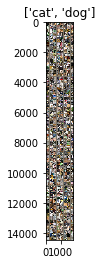

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in names2idx])

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model = models.resnet18(pretrained=True)


In [0]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze the weights of all layers
for param in model.parameters():
  param.requires_grad = False

In [0]:
num_classes = 2
model.fc = nn.Linear(512, num_classes)

model = model.to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), 0.001)
criterion = nn.CrossEntropyLoss()
dataset_sizes = {phase:len(dataset_fetchers[phase]) for phase in dataset_fetchers.keys()}

In [0]:
num_epochs = 10
for epoch in range(num_epochs):
  start_time = time.time()
  cumulative_loss = 0.0
  correct_count = 0.0
  for images, labels in dataloaders['train']:
    images = images.to(device)
    labels = labels.to(device)

    
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(True):
      scores = model(images)
      _, preds = torch.max(scores, 1)
      loss = criterion(scores, labels)
      loss.backward()
      optimizer.step()
    cumulative_loss += loss.item()
    correct_count += torch.sum(preds == labels.data)
  epoch_loss = cumulative_loss /dataset_sizes['train']
  epoch_acc = correct_count.double()/dataset_sizes['train']
  print("Train accuracy {} Train loss {} Time {}".format(epoch_acc, epoch_loss, time.time() - start_time))

Train accuracy 0.9381200000000001 Train loss 0.0002906925594806671 Time 169.52438259124756
Train accuracy 0.936 Train loss 0.0002899778312444687 Time 167.25378966331482
Train accuracy 0.9437200000000001 Train loss 0.0002601635330915451 Time 165.73525476455688
Train accuracy 0.9422 Train loss 0.0002659304216504097 Time 163.59238195419312
Train accuracy 0.9444800000000001 Train loss 0.0002525960034132004 Time 164.29846262931824
Train accuracy 0.9447200000000001 Train loss 0.00024923337280750277 Time 170.71767020225525
Train accuracy 0.9462400000000001 Train loss 0.0002482990065217018 Time 164.96368837356567
Train accuracy 0.9453600000000001 Train loss 0.00025077066123485565 Time 166.0013289451599
Train accuracy 0.9464800000000001 Train loss 0.00024269271194934846 Time 165.4838366508484
Train accuracy 0.94588 Train loss 0.00024192447543144226 Time 165.98288297653198
